In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import sys
import hardware_control.wx_programs as wx
import hardware_control.bnc as bnc
from classes.generator import *
from hardware_control.hardware_config import *
from experiment_configuration.values import *
from classes.qubit_class import *
import daq.daq_programs_homo as daq
import seaborn as sns
import standard_sequences.rabi as rabi
import analysis.plotting as plotting
import analysis.analysis as analysis

In [2]:
q1 = Qubit(q1_dict, readout_dict)
q2 = Qubit(q2_dict, readout_dict)
readout = Readout(readout_dict)
print(f"{q1}\n{q2}")

Qubit(ro_amp=1, ge_amp=1, ge_time=66, IQ_angle=205, ef_amp=0.5, ef_time=76, RO_LO=6.6247, RO_IF=None, qubit_id=q1, RO_LO_pwr=16, ro_freq=6.7275, ro_dur=4000, ROIF=0.10280000000000022, qubit_thr=[-10000, -600], ef_ssm=-0.257, ge_ssm=-0.114)
Qubit(ro_amp=1, ge_amp=1, ge_time=23.610582067254867, IQ_angle=85, ef_amp=1, ef_time=None, RO_LO=6.6247, RO_IF=None, qubit_id=q2, RO_LO_pwr=16, ro_freq=6.6556, ro_dur=4000, ROIF=0.030899999999999928, qubit_thr=[-10000, 1900], ef_ssm=-0.224, ge_ssm=-0.154)


In [3]:
wx_addr = wx.get_wx_address()
main_directory = r"C:\Users\quantum1\Documents"
save_dir = rf"{main_directory}\Python Scripts\Important Blue Fridge Python Files\New\nonlinear_QM\data"
target_bnc_address_6 = "USB0::0x03EB::0xAFFF::411-433500000-0753::INSTR"
bnc.set_bnc_output(
    general_vals_dict["qubit_bnc"], power_dBm=13, bnc_addr=target_bnc_address_6
)

In [4]:
def run_rabi(
    q1: object,
    q2: object,
    general_vals_dict: dict,
    num_steps: int,
    sweep_time: float,
    reps: int,
):
    """
    Runs a single instance of the geRabi experiment
    and processes the resulting IQ data to compute probabilities vs. time.

    Returns:
        df_prob (pd.DataFrame): A DataFrame whose index is the time (computed as
                                np.linspace(0, sweep_time/1000, num_steps)) and which has
                                columns ['P_f', 'P_e', 'P_g'] corresponding to the probabilities
                                of the f, e, and g states respectively.
    """
    # Run the experiment
    rabi.rabi_ge(q1, q2, general_vals_dict, num_steps, sweep_time)
    wx.wx_set_and_amplitude_and_offset(
        amp=general_vals_dict["wx_amps"], offset=general_vals_dict["wx_offs"]
    )
    # Acquire the raw IQ data
    values = daq.run_daq_het_2q(
        q1, q2, num_patterns=num_steps, num_records_per_pattern=reps, verbose=True
    )

    # Retrieve raw IQ data from the acquired values
    I1_raw = values.rec_readout_1[0]
    Q1_raw = values.rec_readout_1[1]
    I2_raw = values.rec_readout_2[0]
    Q2_raw = values.rec_readout_2[1]

    # Build a DataFrame from the IQ data for classification
    IQ_df = pd.DataFrame({"I1": I1_raw, "Q1": Q1_raw, "I2": I2_raw, "Q2": Q2_raw})
    return values, IQ_df

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 101
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
0, No error
0, No error
0, No error
0, No error
0, No error
Patterns: 101
Records per pattern: 1000
Buffers per acquistion: 33
DAQ samples per pattern: 8192
0, No error
Capturing 33 buffers. Press <enter> to abort
Capture completed in 13.059965 sec
Captured 33 buffers (2.526806 buffers per sec)
Captured 101376 records (7762.348300 records per sec)
Transferred 1660944384 bytes (127178314.542097 bytes per sec)


<Figure size 800x800 with 0 Axes>

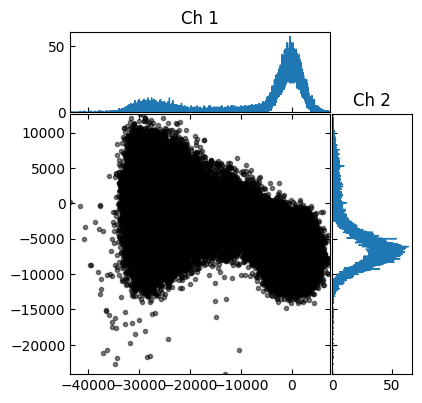

<Figure size 800x800 with 0 Axes>

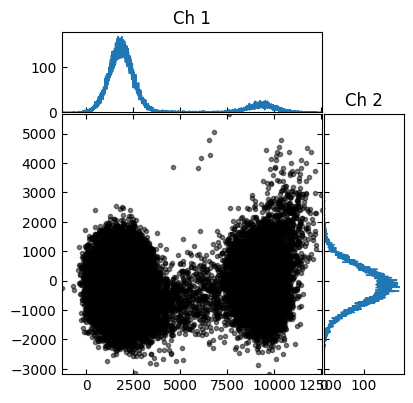

In [6]:
num_steps = 101
reps = 1000
sweep_time = 100
values, IQ_df = run_rabi(q1, q2, general_vals_dict, num_steps, sweep_time, reps)

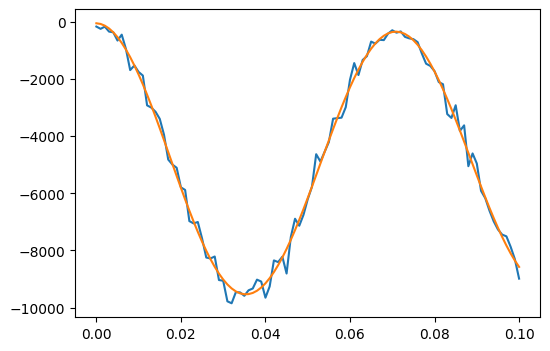



  freq: 14.089586643327598 +/- 0.04550795466168871
 gamma: 0.884377754220451 +/- 0.3063623437143235
   amp: 4821.300642139394 +/- 79.7524494894944
 phase: 90.025513440674 +/- 0.988056192623957
offset: -4866.079441162803 +/- 28.961623305155527
pi_pulse time: 0.03548720148130001 +/- 0.04550795466168871
π_ge time = 35.48720148130001 ns


In [8]:
IQ_df = plotting.get_IQ_averages(values)
Q = IQ_df["Q1"]
I = IQ_df["I1"]
Qrange = abs(np.max(Q) - np.min(Q))
Irange = abs(np.max(I) - np.min(I))
if Qrange > Irange:
    times = np.linspace(0, sweep_time / 1000, num_steps)
    pi_ge_fit_vals, _, _, _ = analysis.fit_sine_decay(
        times, Q, guess_vals=[11, 0.3, np.abs(np.max(Q) - np.min(Q)), 38, Q[0]]
    )
    pi_ge = abs((1 / 2 / pi_ge_fit_vals[0]) * 1000)
    print("\u03C0_ge time = {} ns".format(pi_ge))
else:
    times = np.linspace(0, sweep_time / 1000, num_steps)
    pi_ge_fit_vals, _, _, _ = analysis.fit_sine_decay(
        times, I, guess_vals=[11, 0.3, np.abs(np.max(I) - np.min(I)), 38, I[0]]
    )
    pi_ge = abs((1 / 2 / pi_ge_fit_vals[0]) * 1000)
    print("\u03C0_ge time = {} ns".format(pi_ge))

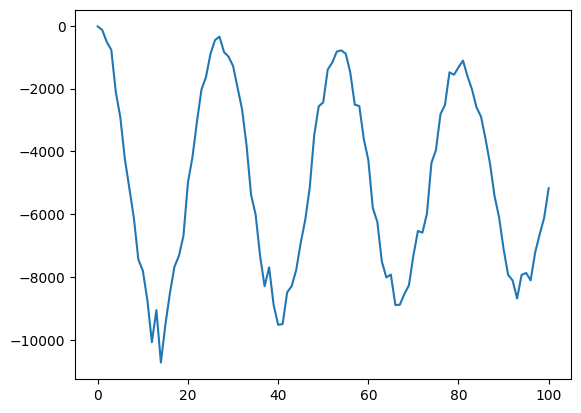

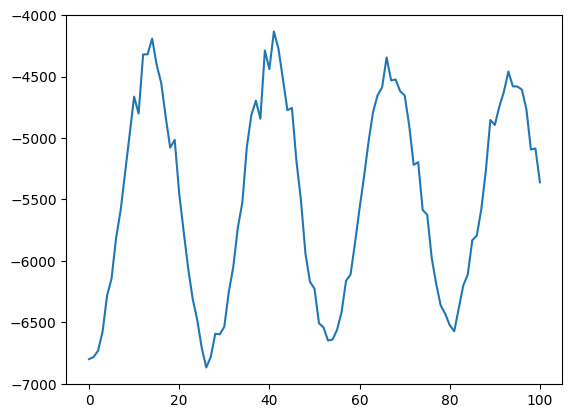

In [ ]:
plt.plot(I)
plt.show()
plt.plot(Q)
plt.show()